In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import bemcs

warnings.filterwarnings("ignore")


# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        n_els = len(x_normals)

        self.x_normals = np.zeros(n_pts * n_els)
        self.y_normals = np.zeros(n_pts * n_els)
        self.x_shears = np.zeros(n_pts * n_els)
        self.y_shears = np.zeros(n_pts * n_els)

        for i in range(0, n_els):
            index = range(i * n_pts, (i + 1) * n_pts)
            self.x_normals[index] = x_normals[i]
            self.y_normals[index] = y_normals[i]
            self.x_shears[index] = x_shears[i]
            self.y_shears[index] = y_shears[i]

# Example: Right angle step
Consider a 3-element planar fault, and we impose slip on the node centers. We will pick values that ensure that stresses are bounded everywhere in the medium.

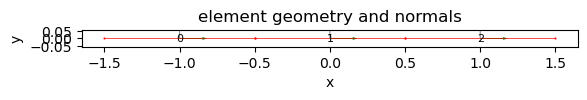

Number of open nodes = 2
: [array([0]), array([8])]
Number of 2-overlap nodes = 2
: [array([ 3, -2]), array([ 6, -5])]
Number of triple junctions = 0
: []


In [2]:
els = bemcs.initialize_els()

# setup a vertical fault with nodes ordered "the correct" way
els.x1 = np.array([-1.5, -0.5, 0.5])
els.y1 = np.array([0.0, 0.0, 0.0])
els.x2 = np.array([-0.5, 0.5, 1.5])
els.y2 = np.array([0.0, 0.0, 0.0])

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations


# Imposed slip (specified in $x,y$ direction)

In [3]:
# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array(
    [0.25, 1.5, 0.25]
)  # for these values - there is no singularity!
# slip_vector_x = np.array([0.5, 1.5, 0.25]) # if you want there to be a weak singularity
slip_vector_y = np.array([0.0, 0.0, 0.0])

# Build BEM linear operator and solve system of equations

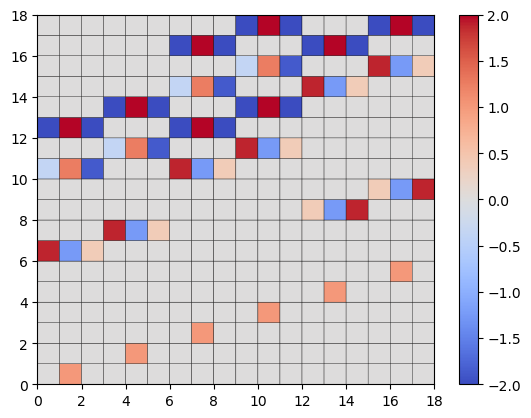

In [4]:
Nequations = N_c + N_o + N_i
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = slip_vector_x
BC_c[1::2, 0] = slip_vector_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i))
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
# populate matrix_system for central nodes
matrix_system_c[0::2, :] = slip_mat[2::6, :]
matrix_system_c[1::2, :] = slip_mat[3::6, :]

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

plt.figure()
plt.pcolor(matrix_system, cmap="coolwarm", edgecolors="k")
plt.colorbar()
plt.clim(-2, 2)
plt.show()

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(matrix_system) @ BCvector.reshape(-1)

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

## Print slip and slip gradient values at nodes

[[-4.99600361e-16  0.00000000e+00]
 [ 2.50000000e-01  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 1.50000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 2.50000000e-01  0.00000000e+00]
 [-5.55111512e-17  0.00000000e+00]]
[[ 3.99680289e-15  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00  0.00000000e+00]
 [-3.33066907e-16  0.00000000e+00]
 [-2.00000000e+00  0.00000000e+00]
 [-2.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  0.00000000e+00]
 [-4.44089210e-16  0.00000000e+00]]


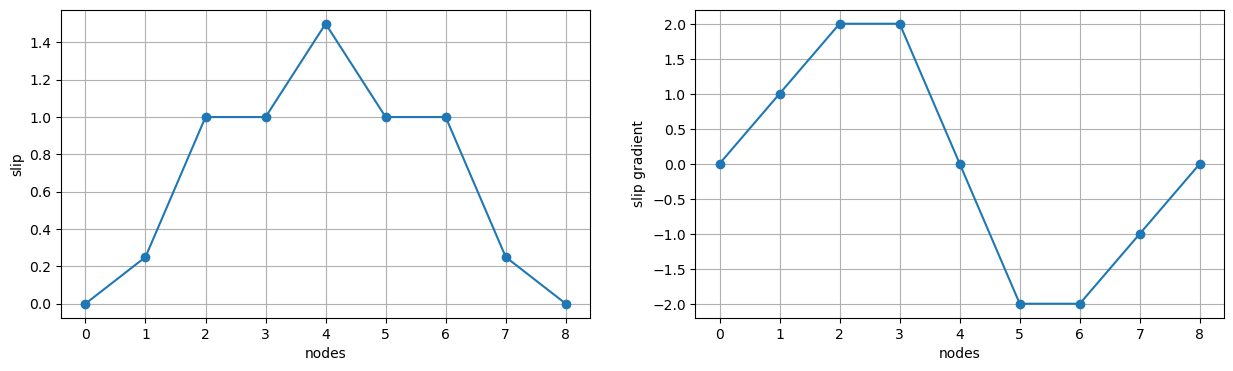

In [5]:
print(
    np.hstack(
        (
            (slip_mat @ coeffs).reshape(-1, 1)[0::2],
            (slip_mat @ coeffs).reshape(-1, 1)[1::2],
        )
    )
)

print(
    np.hstack(
        (
            (slip_gradient_mat @ coeffs).reshape(-1, 1)[0::2],
            (slip_gradient_mat @ coeffs).reshape(-1, 1)[1::2],
        )
    )
)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot((slip_mat @ coeffs)[0::2], "o-")
plt.xlabel("nodes")
plt.ylabel("slip")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot((slip_gradient_mat @ coeffs)[0::2], "o-")
plt.xlabel("nodes")
plt.ylabel("slip gradient")
plt.grid()
plt.show()

### Compute and plot displacements and tractions along elements


In [6]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Compute displacements along a line
n_pts = 1000
dr = 1e-8

els_obs = els_normals(els, n_pts)
x_obs = np.zeros((len(els.x1) * n_pts, 1))
y_obs = np.zeros((len(els.x1) * n_pts, 1))

for i in range(0, len(els.x1)):
    index = range(i * n_pts, (i + 1) * n_pts)
    x_obs[index, 0] = np.linspace(els.x1[i], els.x2[i], n_pts) + dr * els.x_normals[i]
    y_obs[index, 0] = np.linspace(els.y1[i], els.y2[i], n_pts) + dr * els.y_normals[i]

_, _, fault_slip_x, fault_slip_y = bemcs.get_slipvector_on_fault(els, coeffs, n_pts)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_p, uy_p, sxx_p, syy_p, sxy_p = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx_p = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty_p = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

# Plot results

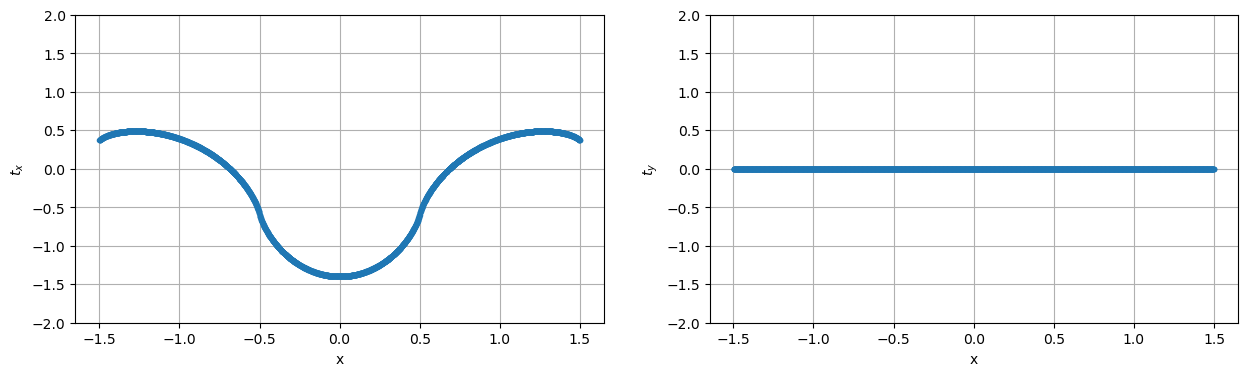

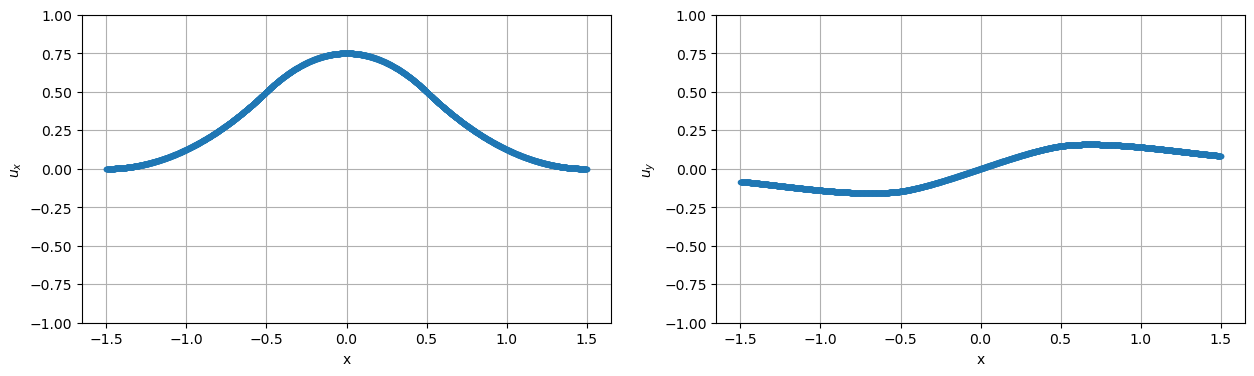

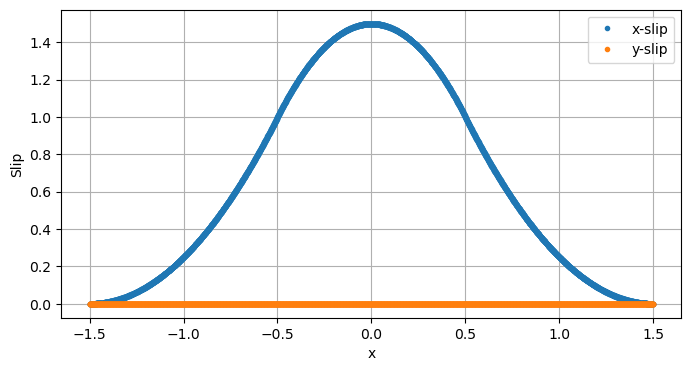

In [7]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, tx_p, ".")
plt.grid()
plt.xlabel("x")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(x_obs, ty_p, ".")
plt.grid()
plt.xlabel("x")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux_p, ".")
plt.grid()
plt.ylim(-1, 1)
plt.xlabel("x")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(x_obs, uy_p, ".")
plt.grid()
plt.ylim(-1, 1)
plt.xlabel("x")
plt.ylabel("$u_y$")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(x_obs, fault_slip_x, ".", label="x-slip")
plt.plot(x_obs, fault_slip_y, ".", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("Slip")
plt.show()

# Plot displacements and stresses in the medium

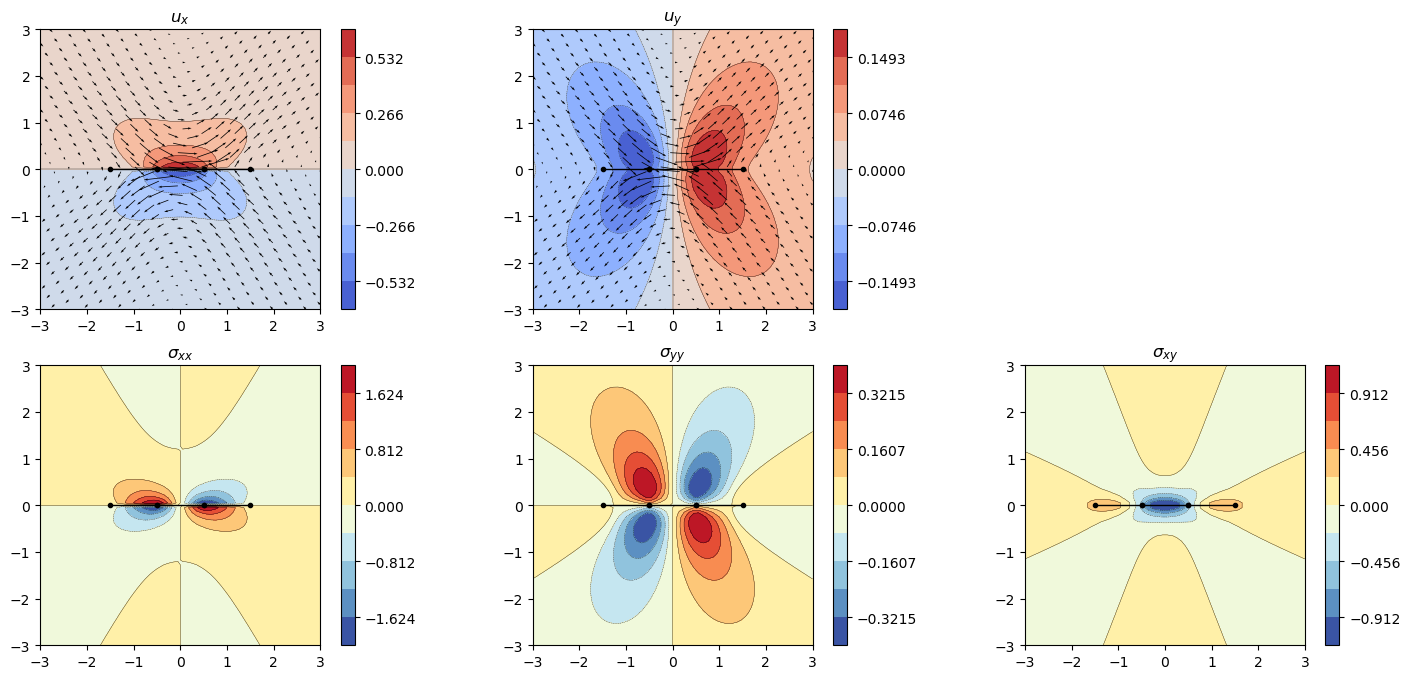

In [8]:
nx = 60
ny = nx
xvec = np.linspace(-3, 3, nx)
yvec = np.linspace(-3, 3, ny)

x_obs, y_obs = np.meshgrid(xvec, yvec)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()
# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

bemcs.plot_displacements_stresses_els(
    els, nx, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=7
)